In [1]:
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import seaborn as sns

import math
import torch.nn as nn
import torch
import torch.utils
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [2]:
file = np.load(os.path.join('plots/plot_plane_normal-100', 'plane.npz'))

In [3]:
file['tr_loss'].shape

(21, 21)

In [4]:
X = file['grid'].reshape(-1, 2)
y = file['tr_loss'].reshape(-1)

In [5]:
X[:, 0] = (X[:, 0] - X[:, 0].mean())/X[:, 0].std()
X[:, 1] = (X[:, 1] - X[:, 1].mean())/X[:, 1].std()

In [6]:
X[:, 1].var()

0.9999999999999998

In [7]:
# X

In [8]:
y.shape

(441,)

In [109]:
class Quadric(nn.Module):
    def __init__(self, ):
        super(Quadric, self).__init__()
        
#         data_Q = torch.FloatTensor(np.random.normal(size=(2,2)))
#         data_P = torch.FloatTensor(np.random.normal(size=(2,)))
#         data_R = torch.FloatTensor(np.random.normal(size=(1,)))
#         data_b = torch.FloatTensor(np.random.normal(size=(1,)))
        
        data_Q = torch.FloatTensor([[2, 0], [0,0]])
        data_P = torch.FloatTensor([0,1])
        data_R = torch.FloatTensor([-1])
        data_b = torch.FloatTensor([0])
        data_b1 = torch.FloatTensor([0.017])
        data_a = torch.FloatTensor([1])
#         data_p = torch.FloatTensor([1])
        
        self.Q = nn.Parameter(data = data_Q, requires_grad=True)
        self.P = nn.Parameter(data = data_P, requires_grad=True)
        self.R = nn.Parameter(data = data_R, requires_grad=True)
        self.b = nn.Parameter(data = data_b, requires_grad=True)
        self.b1 = nn.Parameter(data = data_b1, requires_grad=True)
        self.a = nn.Parameter(data = data_a, requires_grad=True)
#         self.p = nn.Parameter(data = data_p, requires_grad=True)

    def forward(self, x):
        
        q = x @ self.Q 
        q = (x*q).sum(-1)
        p = x @ self.P
        out = nn.ReLU()(torch.abs(q+p+self.R)+self.b)
        out = self.a*out.pow(1.5)+self.b1
#         
#         
#         out = q+p+self.R
#         out = self.a*out*out+self.b

        return out
    
class Appr(nn.Module):
    def __init__(self, ):
        super(Appr, self).__init__()
        
        self.Q1 = Quadric()
        self.Q2 = Quadric()

    def forward(self, x):
        
        x1 = self.Q1(x)
#         x2 = self.Q2(x)

#         out = nn.ReLU()(x1-x2)+nn.ReLU()(x2-x1)
        out = x1
        return out
    
    
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        
        self.mid = 10
        
        self.seq = nn.Sequential(
            nn.Linear(2, self.mid),
            nn.Tanh(),
            nn.Linear(self.mid, self.mid),
            nn.Tanh(),
            nn.Linear(self.mid, 1),
        )
               

    def forward(self, x):
        
        out = self.seq(x)

        return out
    

In [110]:
model = Quadric()

In [111]:
# list(model.parameters())

In [112]:
model.cuda()

Quadric()

In [113]:
# list(model.parameters())[-1].requires_grad_(False)
list(model.parameters())[-1].requires_grad_(True)

Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)

In [114]:
def iterate_minibatches(train_data, train_labels, batchsize):
    indices = np.random.permutation(np.arange(len(train_labels)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield torch.FloatTensor(train_data[ix]).cuda(), torch.FloatTensor(train_labels[ix]).cuda()

In [115]:
# criterion = nn.MSELoss()
criterion = nn.L1Loss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from sklearn.metrics import accuracy_score

def train(model, criterion, optimizer, X, y, batch_size=128, n_epochs=3):

    for epoch in range(n_epochs):
        o_loss = 0
        for X_tr, y_true in iterate_minibatches(X, y, batch_size):

            y_pred = model(X_tr)
            loss = criterion(y_true, y_pred)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            o_loss+=loss
        
        if (epoch % 1000 ==0):
            print('loss:', o_loss)
        
    print("Finished!")

In [116]:
train(model, criterion, optimizer, X, y, batch_size=500, n_epochs=10000)

loss: tensor(2.5674, device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor(0.2660, device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor(0.1714, device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor(0.1198, device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor(0.0883, device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor(0.0723, device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor(0.0690, device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)
loss: tensor(0.0685, device='cuda:0', grad_fn=<AddBackward0>)
Finished!


In [117]:
# list(model.parameters())

In [118]:
y_pred = model(torch.Tensor(X).cuda())

In [119]:
y_pred[10:20]

tensor([0.7390, 1.0313, 1.3824, 1.7964, 2.2777, 2.8306, 3.4593, 4.1682, 4.9618,
        5.8443], device='cuda:0', grad_fn=<SliceBackward>)

In [120]:
y[10:20]

array([0.67497669, 0.91317446, 1.26886076, 1.63645725, 2.1780823 ,
       2.82264527, 3.46282067, 4.38531768, 5.30141304, 6.35336274])

In [121]:
y_pred = y_pred.cpu().data.view(21, 21).numpy()

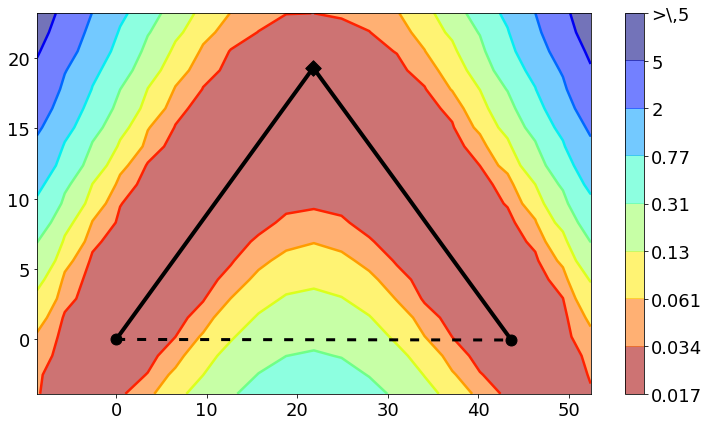

/home/anokhin/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/anokhin/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:1091: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/anokhin/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/anokhin/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:1091: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable 

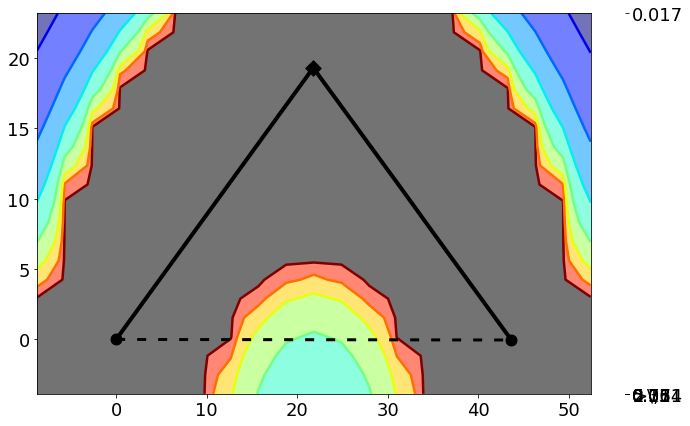

In [122]:
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import seaborn as sns


file = np.load(os.path.join('plots/plot_plane_normal-100', 'plane.npz'))


class LogNormalize(colors.Normalize):

    def __init__(self, vmin=None, vmax=None, clip=None, log_alpha=None):
        self.log_alpha = log_alpha
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        log_v = np.ma.log(value - self.vmin)
        log_v = np.ma.maximum(log_v, self.log_alpha)
        return 0.9 * (log_v - self.log_alpha) / (np.log(self.vmax - self.vmin) - self.log_alpha)


def plane(grid, values, vmax=None, log_alpha=-5, N=7, cmap='jet_r', levels=None):
    cmap = plt.get_cmap(cmap)
    if vmax is None:
        clipped = values.copy()
    else:
        clipped = np.minimum(values, vmax)
    log_gamma = (np.log(clipped.max() - clipped.min()) - log_alpha) / N
    if levels is None:
        levels = clipped.min() + np.exp(log_alpha + log_gamma * np.arange(N + 1))
        levels[0] = clipped.min()
        levels[-1] = clipped.max()
        levels = np.concatenate((levels, [1e10]))
    norm = LogNormalize(clipped.min() - 1e-8, clipped.max() + 1e-8, log_alpha=log_alpha)
    contour = plt.contour(grid[:, :, 0], grid[:, :, 1], values, cmap=cmap, norm=norm,
                          linewidths=2.5,
                          zorder=1,
                          levels=levels)
    contourf = plt.contourf(grid[:, :, 0], grid[:, :, 1], values, cmap=cmap, norm=norm,
                            levels=levels,
                            zorder=0,
                            alpha=0.55)
    colorbar = plt.colorbar(format='%.2g')
    labels = list(colorbar.ax.get_yticklabels())
    labels[-1].set_text(r'>\,' + labels[-2].get_text())
    colorbar.ax.set_yticklabels(labels)
    return contour, contourf, colorbar, levels

plt.figure(figsize=(12.4, 7))

contour, contourf, colorbar, levels = plane(
    file['grid'],
    file['tr_loss'],
    vmax=5.0,
    log_alpha=-5.0,
    N=7
)

bend_coordinates = file['bend_coordinates']
curve_coordinates = file['curve_coordinates']

plt.scatter(bend_coordinates[[0, 2], 0], bend_coordinates[[0, 2], 1], marker='o', c='k', s=120, zorder=2)
plt.scatter(bend_coordinates[1, 0], bend_coordinates[1, 1], marker='D', c='k', s=120, zorder=2)
plt.plot(curve_coordinates[:, 0], curve_coordinates[:, 1], linewidth=4, c='k', label='w(t)', zorder=4)
plt.plot(bend_coordinates[[0, 2], 0], bend_coordinates[[0, 2], 1], c='k', linestyle='--', dashes=(3, 4), linewidth=3, zorder=2)

plt.margins(0.0)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
colorbar.ax.tick_params(labelsize=18)
plt.show()

plt.figure(figsize=(12.4, 7))

contour, contourf, colorbar, _ = plane(
    file['grid'],
    y_pred,
    vmax=5.0,
    log_alpha=-5.0,
    N=7,
    levels=levels
)

bend_coordinates = file['bend_coordinates']
curve_coordinates = file['curve_coordinates']

plt.scatter(bend_coordinates[[0, 2], 0], bend_coordinates[[0, 2], 1], marker='o', c='k', s=120, zorder=2)
plt.scatter(bend_coordinates[1, 0], bend_coordinates[1, 1], marker='D', c='k', s=120, zorder=2)
plt.plot(curve_coordinates[:, 0], curve_coordinates[:, 1], linewidth=4, c='k', label='w(t)', zorder=4)
plt.plot(bend_coordinates[[0, 2], 0], bend_coordinates[[0, 2], 1], c='k', linestyle='--', dashes=(3, 4), linewidth=3, zorder=2)

plt.margins(0.0)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
colorbar.ax.tick_params(labelsize=18)
plt.show()
